# Practice notebook for confidence intervals using NHANES data

This notebook will give you the opportunity to practice working with confidence intervals using the NHANES data.

You can enter your code into the cells that say "enter your code here", and you can type responses to the questions into the cells that say "Type Markdown and Latex".

Note that most of the code that you will need to write below is very similar to code that appears in the case study notebook.  You will need to edit code from that notebook in small ways to adapt it to the prompts below.

To get started, we will use the same module imports and read the data in the same way as we did in the case study:

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import scipy.stats 

da = pd.read_csv("nhanes_2015_2016.csv")

## Question 1

Restrict the sample to women between 35 and 50, then use the marital status variable [DMDMARTL](https://wwwn.cdc.gov/Nchs/Nhanes/2015-2016/DEMO_I.htm#DMDMARTL) to partition this sample into two groups - women who are currently married, and women who are not currently married.  Within each of these groups, calculate the proportion of women who have completed college.  Calculate 95% confidence intervals for each of these proportions.

In [2]:
# enter your code here
# restricting the sample to only those age between 35 and 50
db = da[(da['RIDAGEYR']>=35) & (da['RIDAGEYR']<=50)]

# restricting it to only females
db['RIAGENDRx'] = db['RIAGENDR'].replace({1:'Male',2:'Female'})
db = db[db['RIAGENDRx']=='Female']

# making a series DMDMARTLx that explains the responses given in DMDMARTL
db['DMDMARTLx'] = db['DMDMARTL'].replace({1.0:'Married',2.0:'Unmarried',3.0:'Unmarried',4.0:'Unmarried'
                                         ,5.0:'Unmarried',6.0:'Unmarried',77.0:np.nan})

# making a series DMDMARTLx that explains the responses given in DMDMARTL
db['DMDEDUC2x'] = db['DMDEDUC2'].replace({1.0:'not completed college',2.0:'not completed college',3.0:'not completed college',
                                          4.0:'not completed college',5.0:'College graduate',7.0:np.nan,9.0:np.nan})

# calculating the proportions
pr = db.groupby(['DMDMARTLx']).agg({'DMDEDUC2x': lambda x: np.mean(x=='College graduate')})

# The number of people for the calculated proportion
dn = db.groupby(['DMDMARTLx']).agg({'DMDEDUC2x': np.size})

# calculating the estimate of the standard error of each group
sem = np.sqrt((pr*(1-pr)/dn))

# confidence intervals for for both groups
z_multiplier = scipy.stats.norm.ppf(q = 0.95)
lcb = pr-z_multiplier*sem
ucb = pr+z_multiplier*sem

# print confidence intervals
print(list(zip(np.round(lcb.loc['Married'],2),np.round(ucb.loc['Married'],2))))
print(list(zip(np.round(lcb.loc['Unmarried'],2),np.round(ucb.loc['Unmarried'],2))))

[(0.32, 0.4)]
[(0.18, 0.25)]


__Q1a.__ Identify which of the two confidence intervals is wider, and explain why this is the case. 

The confidence interval for married women is larger, despite having a larger sample size, because the pr-married estimate is closer to 50% than the pr-unmarried so the standard error of pr-married is wider 

__Q1b.__ Write 1-2 sentences summarizing these findings for an audience that does not know what a confidence interval is (the goal here is to report the substance of what you learned about how marital status and educational attainment are related, not to teach a person what a confidence interval is).

We can see that, on average, a middle age woman who is married is more likely to have completed college than a middle age women who is not married, and the confidence intervals for these two estimates do not overlap

## Question 2

Construct a 95% confidence interval for the proportion of smokers who are female. Construct a 95% confidence interval for the proportion of smokers who are male. Construct a 95% confidence interval for the **difference** between those two gender proportions.

In [3]:
# enter your code here
# restricting to only the female population
da['RIAGENDRx'] = da['RIAGENDR'].replace({1:'Male',2:'Female'})
da['SMQ020x'] = da['SMQ020'].replace({1:'Yes',2:'No',7:np.nan,9:np.nan})

# grouping by smokers and non-smokers
dd = pd.crosstab(da['RIAGENDRx'],da['SMQ020x'])
dd['Total'] = dd['Yes']+dd['No']

# calculating confidence intervals of male and female
female_ci = sm.stats.proportion_confint(dd.loc['Female','Yes'],dd.loc['Female','Total'])
male_ci = sm.stats.proportion_confint(dd.loc['Male','Yes'],dd.loc['Male','Total'])
print(female_ci)
print(male_ci)

# now let's find the confidence interval for the difference between the two gender proportions
# Proportions
pr = da.groupby('RIAGENDRx').agg({'SMQ020x': [lambda x: np.mean(x=='Yes')]})
pr.columns = ['Estimates']

# the sizes
dn = da.groupby('RIAGENDRx').agg({'SMQ020x': np.size})
dn.columns = ['Estimates']

# calculating the standard errors
se = np.sqrt(pr * (1 - pr) / dn)

# Standard error for the difference in female/male smoking rates
sem_diff = np.sqrt(se.loc['Female']**2+se.loc['Male']**2)

# Now calculating the ci for the difference
prop_diff = pr.loc['Female']-pr.loc['Male']
lcb = prop_diff - z_multiplier * sem_diff
ucb = prop_diff + z_multiplier * sem_diff
ci = list(zip(lcb,ucb))
ci

(0.2882949879861214, 0.32139545615923526)
(0.49458749263718593, 0.5319290347874418)


[(-0.22862362382619214, -0.1867895693597447)]

__Q2a.__ Why might it be relevant to report the separate gender proportions **and** the difference between the gender proportions?

When we look at the confidence interval for the males who smoke and the proportion of females who smoke, we see how they behave marginally. That is, we see how they behave in their own group. But in order to compare them directly, we also have to compute the confidence interval for the difference. This makes sure that the two samples are compared fairly and we, as much as possible, control for sample size differences.

__Q2b.__ How does the **width** of the confidence interval for the difference between the gender proportions compare to the widths of the confidence intervals for the separate gender proportions?

The width for the difference in proportions will always be larger than the widths of the two intervals it is made from. This happens because of the way the standard error is composed. In general, $\sqrt{A} < \sqrt{A + B}$ when $B > 0$

## Question 3

Construct a 95% interval for height ([BMXHT](https://wwwn.cdc.gov/Nchs/Nhanes/2015-2016/BMX_I.htm#BMXHT)) in centimeters.  Then convert height from centimeters to inches by dividing by 2.54, and construct a 95% confidence interval for height in inches.  Finally, convert the endpoints (the lower and upper confidence limits) of the confidence interval from inches to back to centimeters   

In [4]:
# enter your code here
da['BMXHTx'] = da['BMXHT']/2.54
ci = sm.stats.DescrStatsW(da['BMXHTx'].dropna()).zconfint_mean()
lcb = float(ci[0])
ucb = float(ci[1])
lcb = lcb * 2.54
ucb = ucb * 2.54
ci = ((lcb,ucb))
ci

(165.88055125872887, 166.4051176994943)

__Q3a.__ Describe how the confidence interval constructed in centimeters relates to the confidence interval constructed in inches.

They are equal. The units of a measurement should not impact how the statistical inference on that quantity is performed for confidence intervals like these

## Question 4

Partition the sample based on 10-year age bands, i.e. the resulting groups will consist of people with ages from 18-28, 29-38, etc. Construct 95% confidence intervals for the difference between the mean BMI for females and for males within each age band.

In [5]:
# enter your code here
da['agegrp'] = pd.cut(da['RIDAGEYR'],[10,20,30,40,50,60,70,80])
de = da.groupby(['agegrp','RIAGENDRx']).agg({'BMXBMI':['mean','std',np.size]}).unstack()

# Calculate the SEM for females and for males within each age band
de['BMXBMI','sem','Female'] = de['BMXBMI','std','Female']/np.sqrt(de['BMXBMI','size','Female'])
de['BMXBMI','sem','Male'] = de['BMXBMI','std','Male']/np.sqrt(de['BMXBMI','size','Male'])

# calculate the sem_difference and mean_difference
de['BMXBMI','sem_diff',''] = np.sqrt(de['BMXBMI','sem','Female']**2 + de['BMXBMI','sem','Male']**2)
de['BMXBMI','mean_diff',''] = de['BMXBMI','mean','Female'] - de['BMXBMI','mean','Male'] 

# Get the degrees of freedom (df = n - 1), note: n = size
df_male = de['BMXBMI','size','Male'] - 1
df_female = de['BMXBMI','size','Female'] - 1

# Get the minimum degrees of freedom for a more conservative estimate
for n in range(de.shape[0]):
    if df_male.iloc[n]>df_female.iloc[n]:
        df_min = df_male
    else:
        df_min = df_female
    t_multiplier = scipy.stats.t.ppf(1 - (1 - 0.95) / 2, df_min)
    de['BMXBMI','lcb',''] = de['BMXBMI','mean_diff',''] - t_multiplier * de['BMXBMI','sem_diff',''] 
    de['BMXBMI','ucb',''] = de['BMXBMI','mean_diff',''] + t_multiplier * de['BMXBMI','sem_diff','']
de

BMXBMI                                                       \
                mean                  std             size            sem   
RIAGENDRx     Female       Male    Female      Male Female Male    Female   
agegrp                                                                      
(10, 20]   26.435625  26.230286  6.969054  7.024190    165  175  0.542540   
(20, 30]   28.422309  27.712441  7.866190  6.583785    514  432  0.346963   
(30, 40]   30.325586  29.611726  8.315608  6.622412    474  458  0.381949   
(40, 50]   31.160643  29.724623  8.076195  6.407076    502  401  0.360458   
(50, 60]   30.743777  29.231486  7.575848  5.914373    470  454  0.349448   
(60, 70]   31.074828  29.392488  7.604514  5.933307    441  437  0.362120   
(70, 80]   29.138213  27.957692  6.284968  4.974855    410  402  0.310392   

                                                             
                     sem_diff mean_diff       lcb       ucb  
RIAGENDRx      Male                                          
agegrp                                                       
(10, 20]   0.530979  0.759137  0.205339 -1.293602  1.704281  
(20, 30]   0.316762  0.469810  0.709868 -0.213121  1.632857  
(30, 40]   0.309445  0.491570  0.713861 -0.252070  1.679791  
(40, 50]   0.319954  0.481976  1.436019  0.489076  2.382962  
(50, 60]   0.277575  0.446275  1.512291  0.635344  2.389238  
(60, 70]   0.283829  0.460097  1.682340  0.778079  2.586601  
(70, 80]   0.248123  0.397377  1.180521  0.399365  1.961678

__Q4a.__ How do the widths of these confidence intervals differ?  Provide an explanation for any substantial differences in the confidence interval widths that you see.

## Question 5

Construct a 95% confidence interval for the first and second systolic blood pressure measures, and for the difference between the first and second systolic blood pressure measurements within a subject.

In [9]:
# enter code here
dg = da[['BPXSY1','BPXSY2']]
ci1 = sm.stats.DescrStatsW(dg['BPXSY1'].dropna()).zconfint_mean()
ci2 = sm.stats.DescrStatsW(da['BPXSY2'].dropna()).zconfint_mean()
ci1,ci2

dg['diff'] = da['BPXSY1']-da['BPXSY2']

ci3 = sm.stats.DescrStatsW(dg['diff'].dropna()).zconfint_mean()
ci3
print('First Systolic Blood pressure confidence intervals:', ci1)
print('Second Systolic Blood pressure confidence intervals:', ci2)
print('Difference between the First and Second Systolic Blood pressure confidence intervals:', ci3)


First Systolic Blood pressure confidence intervals: (124.59174272058787, 125.57748520016754)
Second Systolic Blood pressure confidence intervals: (124.29493306967777, 125.27110125733216)
Difference between the First and Second Systolic Blood pressure confidence intervals: (0.5400000439676836, 0.8099720178687849)


__Q5a.__ Based on these confidence intervals, would you say that a difference of zero between the population mean values of the first and second systolic blood pressure measures is consistent with the data?

From our data, we estimate with 95% confidence the population mean difference between the first and second systolic blood pressure measures is in between 0.54 and 0.81 units. Since zero is not within this interval, we have sufficient evidence to reject the claim, at the 95% confidence level, that the population mean difference between the first and second systolic blood pressure measures is zero.

__Q5b.__ Discuss how the width of the confidence interval for the within-subject difference compares to the widths of the confidence intervals for the first and second measures.

The within subject variation (the difference of the two measures) is less than the intra-population variation (the variation within the first measure itself and the variation within the second measure itself). This is to say, a person is more like themselves than they are like the population of first and second measures.

## Question 6

Construct a 95% confidence interval for the mean difference between the average age of a smoker, and the average age of a non-smoker.

In [10]:
# insert your code here
di = da.groupby('SMQ020x').agg({'RIDAGEYR':['mean','std',np.size]})
di.columns = ['mean','std','size']
di.loc['No','sem'] = di.loc['No','std']/np.sqrt(di.loc['No','size'])
di.loc['Yes','sem'] = di.loc['Yes','std']/np.sqrt(di.loc['Yes','size'])
df_min = 2319-1
t_multiplier = scipy.stats.t.ppf(1 - (1 - 0.95) / 2, df_min)
lcb = (di.loc['Yes','mean']-di.loc['No','mean']) - t_multiplier * np.sqrt(di.loc['Yes','sem']**2+di.loc['No','sem']**2)
ucb = (di.loc['Yes','mean']-di.loc['No','mean']) + t_multiplier * np.sqrt(di.loc['Yes','sem']**2+di.loc['No','sem']**2)
ci = (lcb,ucb)
ci

(5.891344750556488, 7.782170799330483)

__Q6a.__ Use graphical and numerical techniques to compare the variation in the ages of smokers to the variation in the ages of non-smokers.  

The mean of smokers age is: 52.10
The standard deviation of smokers age is: 17.46


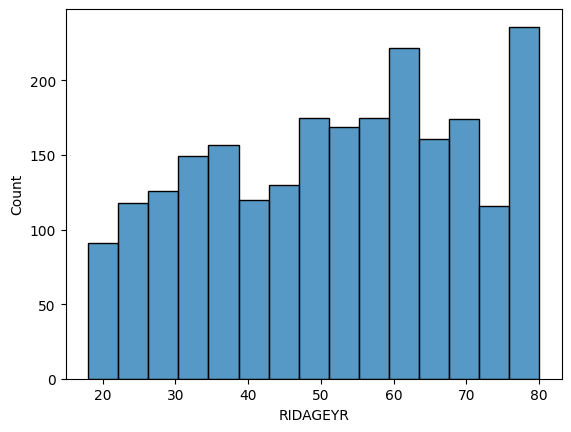

In [231]:
# insert your code here
dj = da['RIDAGEYR'][da['SMQ020x'] == 'Yes']
sns.histplot(dj)
print("The mean of smokers age is: {:.2f}".format(np.mean(dj)))
print("The standard deviation of smokers age is: {:.2f}".format(np.std(dj, ddof = 1)))

__Q6b.__ Does it appear that uncertainty about the mean age of smokers, or uncertainty about the mean age of non-smokers contributed more to the uncertainty for the mean difference that we are focusing on here?

The mean of non-smokers age is: 45.26
The standard deviation of non-smokers age is: 18.54


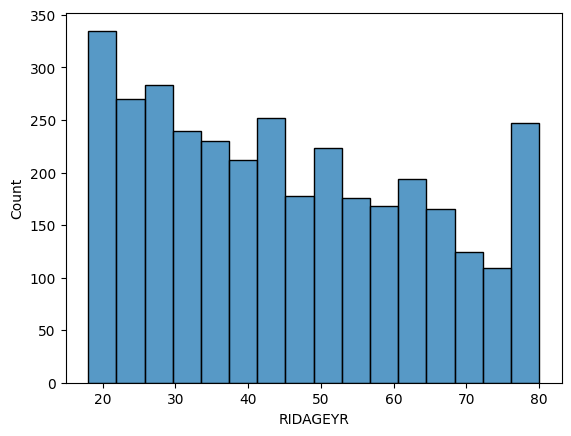

In [232]:
# insert your code here
dk = da['RIDAGEYR'][da['SMQ020x'] == 'No']
sns.histplot(dk)
print("The mean of non-smokers age is: {:.2f}".format(np.mean(dk)))
print("The standard deviation of non-smokers age is: {:.2f}".format(np.std(dk, ddof = 1)))